In [2]:

from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as f
from pyspark.sql.functions import col,avg
from pyspark.sql.types import StructType, StructField, StringType, FloatType

sc = SparkContext()
sqlContext=SQLContext(sc)

sdf = sqlContext.read.csv("./data/tracks_features.csv", header=True, inferSchema=True)
pldf = sqlContext.read.csv("./data/playlists.csv",header=True, inferSchema=True)

23/01/06 09:00:57 WARN Utils: Your hostname, hemera2 resolves to a loopback address: 127.0.1.1; using 10.149.12.167 instead (on interface eno2)
23/01/06 09:00:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/01/06 09:00:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/gogolev/miniconda3/envs/BD/lib/python3.10/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Preprocessing: 
* Remove Nan values (unsuccessfully parsed entries) 
* Rename columns consistently
* separate comma-separated artists --> give each artist-song combination one entry
* remove entries with nonsensical release-year 
* cast numeric columns to correct type

In [3]:
pldf = pldf.dropna() #12902577 --> 12868945
sdf = sdf.dropna()

pldf = pldf.withColumnRenamed(' "artistname"',"artist") \
    .withColumnRenamed("user_id","user") \
    .withColumnRenamed(' "trackname"',"track") \
    .withColumnRenamed(' "playlistname"',"playlist")

sdf = sdf.drop("artist_ids", "album_id") \
    .withColumnRenamed("artists","artist") \
    .withColumnRenamed("name","track")
sdf = sdf.withColumn("artist", f.split(col("artist"), ",")) \
        .withColumn("artist", f.explode(col("artist"))) \
        .withColumn("artist",f.trim(col("artist"))) \
        .withColumn("artist", f.translate(col("artist"),"[]\"'",""))
sdf= sdf.withColumn("year", f.trim(col("year"))) \
                  .withColumn("year", col("year").cast("integer")) \
                  .where(~f.isnull(col("year")))
sdf = sdf.where((col("year") >= 1800) & (col("year") <= 3000)) # years that make no sense

#set correct datatypes
columns_to_cast = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
for column in columns_to_cast:
    sdf = sdf.withColumn(column, col(column).cast("float"))

Join both datasets on the name of the artist and the track

In [4]:
merge_df = pldf.join(sdf, on = ["artist","track"],how = "left") # 13918877 entries
merge_df = merge_df.dropna().persist() #2727713 entries

Calculate some general statistics

In [5]:
num_tracks = merge_df.select("track").distinct().count()
num_artists = merge_df.select("artist").distinct().count()
num_rows = merge_df.count()
print(num_tracks,num_artists,num_rows) # 147538 19759 2727713

147280 19732 2726346


Generate new Dataframes:
* averages over time
* averages over playlists
* add column for song popularity (how many distinct playlists song is in)
* add column for artist popularity (how many distinct playlists artist is in)

In [6]:
sdf_avg = sdf.groupBy("year").avg("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature")
pl_avg = merge_df.groupBy("playlist").avg("danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature")
artist_popularity = merge_df.select("artist", "playlist").distinct().groupBy("artist").count().orderBy(f.desc("count"))
song_popularity = merge_df.select("track", "playlist").distinct().groupBy("track").count().orderBy(f.desc("count"))
merge_pop = merge_df.join(artist_popularity, on="artist", how="left").withColumnRenamed("count", "artist_popularity")
merge_pop = merge_pop.join(song_popularity, on="track", how="left").withColumnRenamed("count", "song_popularity")

What are the most popular artists and songs? 
Popularity := how many distinct playlists a song/artist is included in

In [7]:
print(song_popularity.toPandas().head())
print(artist_popularity.toPandas().head())

                           track  count
0                          Creep   1565
1                         Ho Hey   1551
2                           Kids   1343
3  Rather Be (feat. Jess Glynne)   1279
4               Do I Wanna Know?   1204


            artist  count
0          Beyoncé   3476
1        Radiohead   3406
2   Arctic Monkeys   3038
3         Coldplay   2855
4  Michael Jackson   2593


<AxesSubplot: >

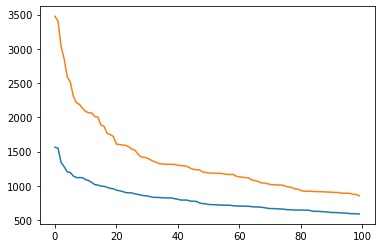

In [8]:
import matplotlib.pyplot as plt

song_popularity.toPandas()["count"][:100].plot()
artist_popularity.toPandas()["count"][:100].plot()

### Attributes over time
Average over numeric attributes

23/01/06 09:01:30 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


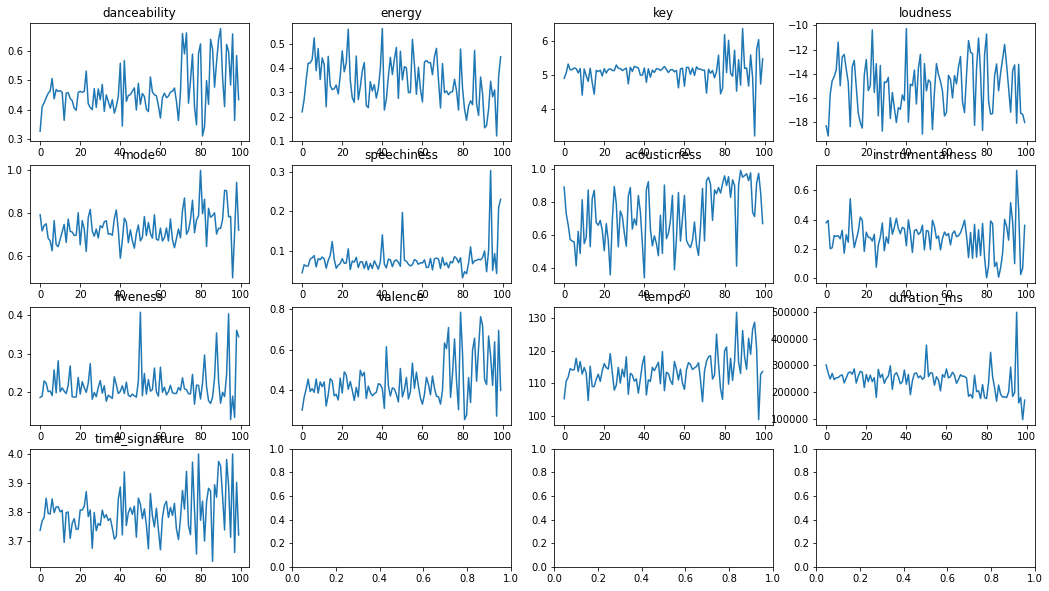

In [9]:
time_pandas = sdf_avg.toPandas()
data = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

# Create a figure with 3 rows and 3 columns of subplots
fig, ax = plt.subplots(4, 4,figsize=(18, 10))

# Iterate over the data series and plot each one in the corresponding subplot
for i, data_series in enumerate(data):
    row = i // 4
    col = i % 4
    idx = f"avg({data_series})"
    ax[row, col].plot(time_pandas[idx])
    ax[row,col].set_title(data_series)

# Show the figure
plt.show()

Median over numeric attributes

TypeError: 'Column' object is not callable

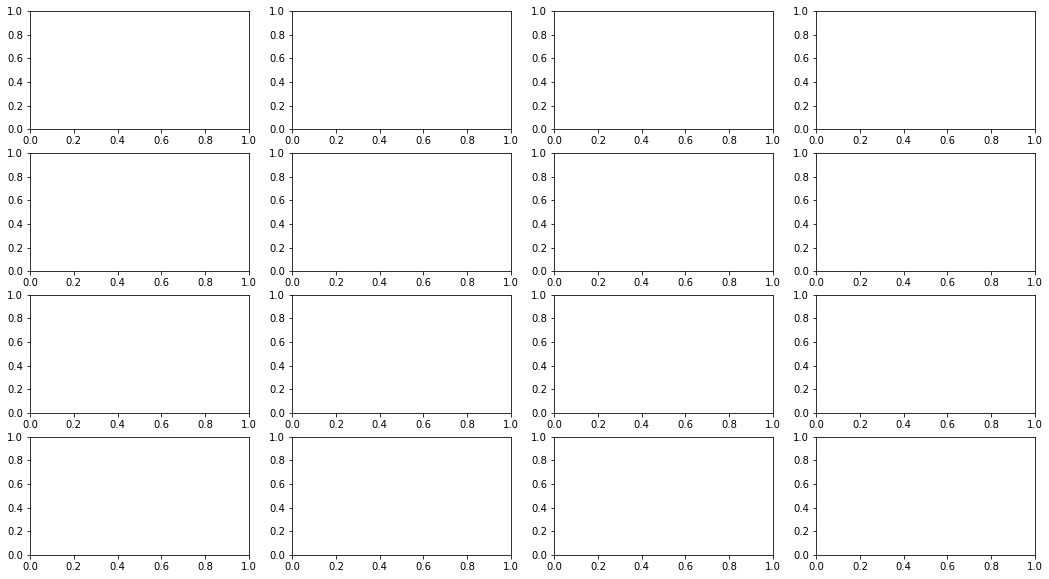

In [10]:


# Approximate the median value of the "energy" column
grouped = sdf.groupBy("year")

fig, ax = plt.subplots(4, 4,figsize=(18, 10))

# Iterate over the data series and plot each one in the corresponding subplot
for i, data_series in enumerate(data):
    row = i // 4
    col = i % 4
    median_energy = grouped.agg(f.col("energy").approxQuantile("energy", [0.5], 0.25))[0]
    print(median_energy)
    ax[row,col].set_title(data_series)

# Show the figure
plt.show()

In [11]:
sc.stop()